# LOAD DATA 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = '../input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/kaggle/input/',dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 1440


,Emotion,Emotion intensity,Gender,Path
0,0,strong,male,/kaggle/input/../input/ravdess-emotional-speec...
1,5,strong,male,/kaggle/input/../input/ravdess-emotional-speec...
2,2,strong,male,/kaggle/input/../input/ravdess-emotional-speec...
3,7,strong,male,/kaggle/input/../input/ravdess-emotional-speec...
4,4,strong,male,/kaggle/input/../input/ravdess-emotional-speec...


number of examples per Emotion

Text(0, 0.5, 'Number of examples')

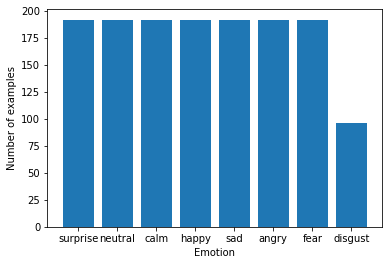

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of examples')

number of examples per gender

Text(0, 0.5, 'Number of examples')

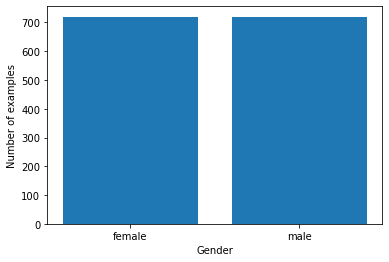

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

number of examples per emotion intensity

Text(0, 0.5, 'Number of examples')

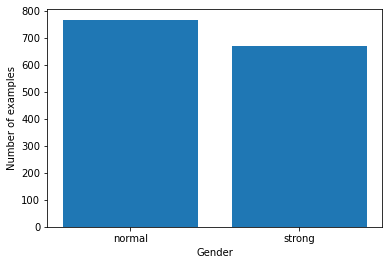

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Emotion intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

# CALCULATE MEL SPECTROGRAM

MEL spectrogram shape:  (128, 563)


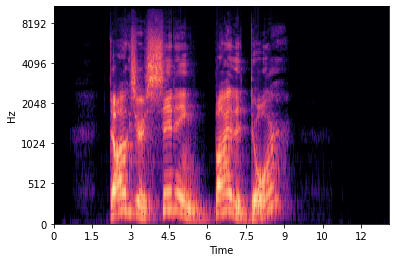

In [6]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

calculate mel spectrograms for all audio files (this can take few minutes to execute)

In [7]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    mel_spectrogram = getMELspectrogram(signal, sample_rate=SAMPLE_RATE)
    mel_spectrograms.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,len(data)),end='')

 Processed 1439/1440 files

augment signals (by adding AWGN) and calculate mel spectrograms

In [8]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [10]:
for i,signal in enumerate(signals):
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        mel_spectrogram = getMELspectrogram(augmented_signals[j,:], sample_rate=SAMPLE_RATE)
        mel_spectrograms.append(mel_spectrogram)
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,len(signals)),end='')

 Processed 1439/1440 files

# SPLIT SPECTROGRAM INTO CHUNKS

In [11]:
def splitIntoChunks(mel_spec,win_size,stride):
    t = mel_spec.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [12]:
# get chunks
mel_spectrograms_chunked = []
for mel_spec in mel_spectrograms:
    chunks = splitIntoChunks(mel_spec, win_size=128,stride=64)
    mel_spectrograms_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

Number of chunks is 7


# CREATE MODEL

In [13]:
import torch
import torch.nn as nn
# BATCH FIRST TimeDistributed layer
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if x.ndim <= 2:
            return self.module(x)
        # squash samples and timesteps into a single axis
        elif x.ndim == 3: # (samples, timesteps, inp1)
            x_reshape = x.contiguous().view(-1, x.size(2))  # (samples * timesteps, inp1)
        elif x.ndim == 4: # (samples,timesteps,inp1,inp2)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) # (samples*timesteps,inp1,inp2)
        else: # (samples,timesteps,inp1,inp2,inp3)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) # (samples*timesteps,inp1,inp2,inp3)
            
        y = self.module(x_reshape)
        
        # we have to reshape Y
        if x.ndim == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))  # (samples, timesteps, out1)
        elif x.ndim == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2)) # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3)) # (samples, timesteps, out1,out2, out3)
        return y

In [14]:
class HybridModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 4. conv block
            TimeDistributed(nn.Conv2d(in_channels=64,
                                   out_channels=128,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(128)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4))
        )
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128,hidden_size=hidden_size,bidirectional=False, batch_first=True) 
        self.dropout_lstm = nn.Dropout(p=0.3)
        # Linear softmax layer
        self.out_linear = nn.Linear(hidden_size,num_emotions)
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        # lstm_embedding (batch, time, hidden_size)
        lstm_output = lstm_embedding[:,-1,:] 
        output_logits = self.out_linear(lstm_output)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax
                                     

In [15]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

# TRAINING

In [16]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [17]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

stack data

In [18]:
X = np.stack(mel_spectrograms_chunked,axis=0)
X = np.expand_dims(X,2)
print('Shape of data: ',X.shape)

del mel_spectrograms
del mel_spectrograms_chunked
del signals

Shape of data:  (4320, 7, 1, 128, 128)


split data: (train,val,test) --> (80%,10%,10%) proportionaly for each emotion (class) 

In [19]:
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:,:,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:,:,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:,:,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(3450, 7, 1, 128, 128), Y_train:(3450,)
X_val:(435, 7, 1, 128, 128), Y_val:(435,)
X_test:(435, 7, 1, 128, 128), Y_test:(435,)
Number of unique indexes is 4320, out of 4320


scale data

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

b,t,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,t,c,h,w))

b,t,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,t,c,h,w))

b,t,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,t,c,h,w))

train the model

In [ ]:
EPOCHS=700
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = HybridModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")
    

Selected device is cuda
Number of trainable params:  147816
 Epoch 0: iteration 106/107
Epoch 0 --> loss:2.0631, acc:13.36%, val_loss:2.0783, val_acc:12.18%
 Epoch 1: iteration 106/107
Epoch 1 --> loss:2.0330, acc:16.03%, val_loss:2.0900, val_acc:14.94%
 Epoch 2: iteration 106/107
Epoch 2 --> loss:1.9941, acc:18.32%, val_loss:2.1136, val_acc:13.56%
 Epoch 3: iteration 106/107
Epoch 3 --> loss:1.9660, acc:20.00%, val_loss:2.1414, val_acc:13.56%
 Epoch 4: iteration 106/107
Epoch 4 --> loss:1.9559, acc:19.94%, val_loss:2.1301, val_acc:15.40%
 Epoch 5: iteration 106/107
Epoch 5 --> loss:1.9370, acc:22.26%, val_loss:2.1006, val_acc:16.32%
 Epoch 6: iteration 106/107
Epoch 6 --> loss:1.9052, acc:24.75%, val_loss:2.1053, val_acc:19.54%
 Epoch 7: iteration 106/107
Epoch 7 --> loss:1.8645, acc:26.90%, val_loss:2.0819, val_acc:18.85%
 Epoch 8: iteration 106/107
Epoch 8 --> loss:1.8013, acc:28.93%, val_loss:1.9719, val_acc:24.83%
 Epoch 9: iteration 106/107
Epoch 9 --> loss:1.7638, acc:29.48%, va

 Epoch 83: iteration 106/107
Epoch 83 --> loss:0.8602, acc:67.36%, val_loss:1.2781, val_acc:51.49%
 Epoch 84: iteration 106/107
Epoch 84 --> loss:0.8206, acc:69.45%, val_loss:1.0281, val_acc:63.68%
 Epoch 85: iteration 106/107
Epoch 85 --> loss:0.8119, acc:69.62%, val_loss:0.9759, val_acc:61.38%
 Epoch 86: iteration 106/107
Epoch 86 --> loss:0.8278, acc:68.96%, val_loss:0.8826, val_acc:65.52%
 Epoch 87: iteration 106/107
Epoch 87 --> loss:0.7884, acc:70.35%, val_loss:1.1414, val_acc:57.47%
 Epoch 88: iteration 106/107
Epoch 88 --> loss:0.7959, acc:70.09%, val_loss:1.0255, val_acc:61.61%
 Epoch 89: iteration 106/107
Epoch 89 --> loss:0.8187, acc:69.94%, val_loss:1.0772, val_acc:56.32%
 Epoch 90: iteration 106/107
Epoch 90 --> loss:0.7533, acc:71.80%, val_loss:1.0127, val_acc:62.76%
 Epoch 91: iteration 106/107
Epoch 91 --> loss:0.7628, acc:71.54%, val_loss:1.1723, val_acc:56.09%
 Epoch 92: iteration 106/107
Epoch 92 --> loss:0.7711, acc:71.10%, val_loss:0.9889, val_acc:62.53%
 Epoch 93:

 Epoch 165: iteration 106/107
Epoch 165 --> loss:0.4194, acc:85.42%, val_loss:0.7508, val_acc:72.18%
 Epoch 166: iteration 106/107
Epoch 166 --> loss:0.4179, acc:84.46%, val_loss:0.5740, val_acc:78.39%
 Epoch 167: iteration 106/107
Epoch 167 --> loss:0.4184, acc:83.68%, val_loss:0.5652, val_acc:77.47%
 Epoch 168: iteration 106/107
Epoch 168 --> loss:0.4203, acc:84.29%, val_loss:0.6999, val_acc:74.25%
 Epoch 169: iteration 106/107
Epoch 169 --> loss:0.4039, acc:84.96%, val_loss:0.7424, val_acc:70.57%
 Epoch 170: iteration 106/107
Epoch 170 --> loss:0.3843, acc:85.68%, val_loss:0.6096, val_acc:76.32%
 Epoch 171: iteration 106/107
Epoch 171 --> loss:0.4112, acc:84.87%, val_loss:0.5898, val_acc:78.39%
 Epoch 172: iteration 106/107
Epoch 172 --> loss:0.4159, acc:84.78%, val_loss:0.7008, val_acc:74.94%
 Epoch 173: iteration 106/107
Epoch 173 --> loss:0.3567, acc:87.10%, val_loss:0.4259, val_acc:82.76%
 Epoch 174: iteration 106/107
Epoch 174 --> loss:0.4107, acc:84.52%, val_loss:0.5808, val_a

# Save model

In [22]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_model.pt')))

Model is saved to /kaggle/working/models/cnn_lstm_model.pt


# Load model

In [23]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm_model.pt')))

Model is loaded from /kaggle/working/models/cnn_lstm_model.pt


# Test

In [24]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.254
Test accuracy is 94.02%


confusion matrix

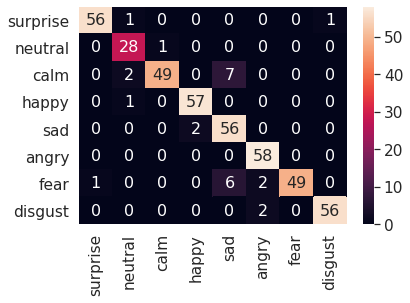

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between emotion intensity and prediction

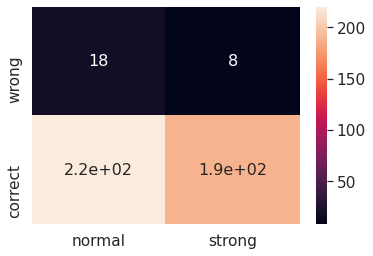

In [26]:
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between gender and corectness

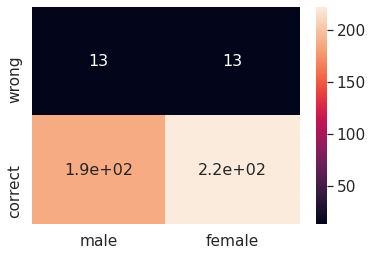

In [27]:
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

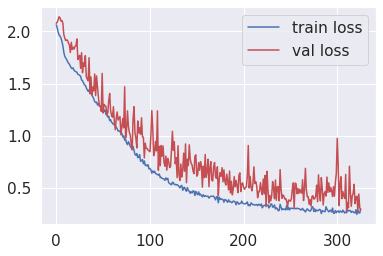

In [28]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])